In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the PlantVillage directory in your Google Drive
plantvillage_path = '/content/drive/My Drive/potato project/PlantVillage'

# Example dataset creation
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    plantvillage_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].shape)

(256, 256, 3)


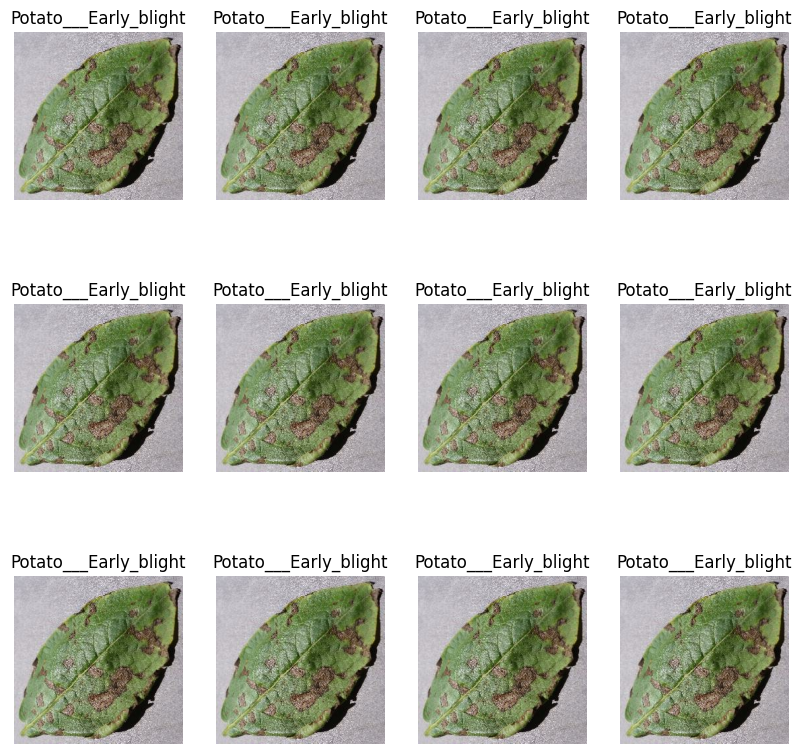

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_df(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Get the total size of the dataset
    ds_size = len(ds)

    # Shuffle the dataset if specified
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    # Calculate the sizes of training, validation, and test sets
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Create the training dataset by taking the first 'train_size' elements
    train_ds = ds.take(train_size)

    # Create the validation dataset by skipping the training set and taking the next 'val_size' elements
    val_ds = ds.skip(train_size).take(val_size)

    # Create the test dataset by skipping the training and validation sets
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_df(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# Image resizing and rescaling preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([
    # Resize images to the specified dimensions (IMAGE_SIZE x IMAGE_SIZE)
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),

    # Rescale pixel values to the range [0, 1]
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [ ]:
# Data augmentation - rotating an image in four directions and training it
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)  # Assuming you intended to rotate with a 0.2 factor
])


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5
54/54 [==============================] - 496s 4s/step - loss: 0.9213 - accuracy: 0.4931 - val_loss: 0.9023 - val_accuracy: 0.5260
Epoch 2/5
54/54 [==============================] - 214s 4s/step - loss: 0.6855 - accuracy: 0.6968 - val_loss: 0.5492 - val_accuracy: 0.7708
Epoch 3/5
54/54 [==============================] - 213s 4s/step - loss: 0.5134 - accuracy: 0.7940 - val_loss: 0.5224 - val_accuracy: 0.8333
Epoch 4/5
54/54 [==============================] - 212s 4s/step - loss: 0.4422 - accuracy: 0.8212 - val_loss: 0.3372 - val_accuracy: 0.8542
Epoch 5/5
54/54 [==============================] - 212s 4s/step - loss: 0.3558 - accuracy: 0.8588 - val_loss: 0.3072 - val_accuracy: 0.8750


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 16s 919ms/step - loss: 0.3137 - accuracy: 0.8867


In [ ]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [ ]:
# Extracting accuracy and loss metrics from training history
acc = history.history['accuracy']        # Training accuracy
val_acc = history.history['val_accuracy'] # Validation accuracy
loss = history.history['loss']            # Training loss
val_loss =  history.history['val_loss']   # Validation loss

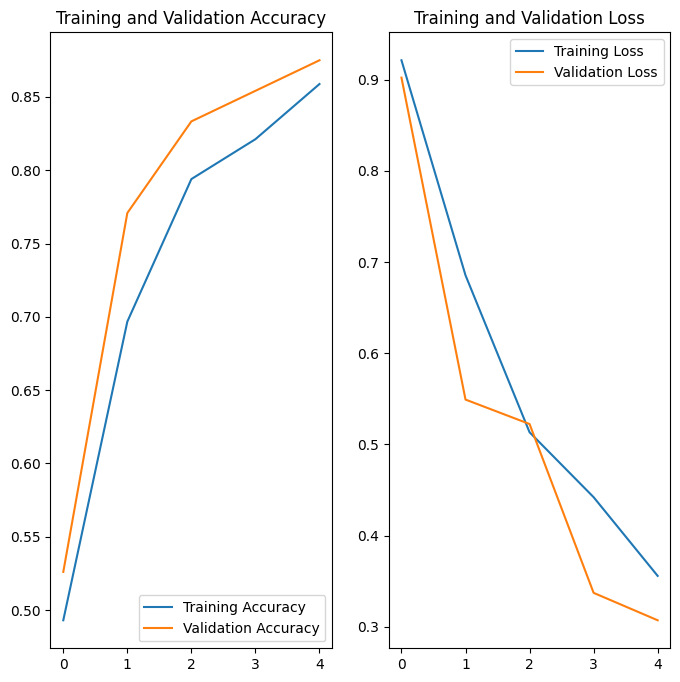

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure with a specified size
plt.figure(figsize=(8, 8))

# Subplot 1: Training and validation accuracy
plt.subplot(1, 2, 1)

# Plot training accuracy
plt.plot(range(EPOCHS), acc, label='Training Accuracy')

# Plot validation accuracy
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')

# Add a legend indicating which line corresponds to which metric
plt.legend(loc='lower right')

# Set the title for the subplot
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and validation loss
plt.subplot(1, 2, 2)

# Plot training loss
plt.plot(range(EPOCHS), loss, label='Training Loss')

# Plot validation loss
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')

# Add a legend indicating which line corresponds to which metric
plt.legend(loc='upper right')

# Set the title for the subplot
plt.title('Training and Validation Loss')

# Show the entire plot
plt.show()

First image to predict
Actual label of the first image: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
Predicted label of the first image: Potato___Early_blight


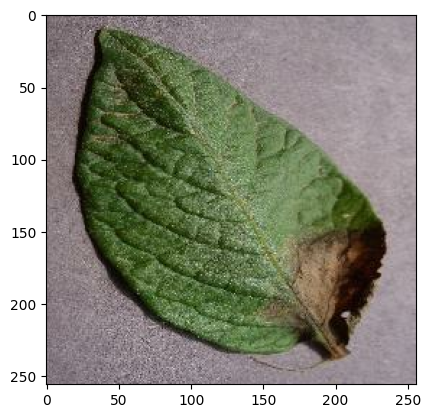

In [ ]:
# Iterate over the first batch of the test dataset
for images_batch, labels_batch in test_ds.take(1):
    # Convert the first image to numpy array and cast it to 'uint8'
    first_image = images_batch[0].numpy().astype('uint8')
    # Get the label of the first image
    first_label = labels_batch[0]

    # Print information about the first image
    print('First image to predict')
    # Display the first image
    plt.imshow(first_image)
    # Print the actual label of the first image
    print('Actual label of the first image:', class_names[first_label])

    # Make predictions for the entire batch of images
    batch_prediction = model.predict(images_batch)
    # Print the predicted class label for the first image in the batch
    print('Predicted label of the first image:', class_names[np.argmax(batch_prediction[0])])


In [ ]:
import tensorflow as tf

def predict(model, img):
    # Convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Expand the dimensions to create a batch (necessary for model.predict)
    img_array = tf.expand_dims(img_array, 0)

    # Use the model to make predictions on the image batch
    predictions = model.predict(img_array)

    # Get the predicted class label
    predicted_class = class_names[np.argmax(predictions[0])]
    # Get the confidence level of the prediction
    confidence = round(100 * np.max(predictions[0]), 2)

    # Return the predicted class label and confidence level
    return predicted_class, confidence


1/1 [==============================] - 0s 71ms/step


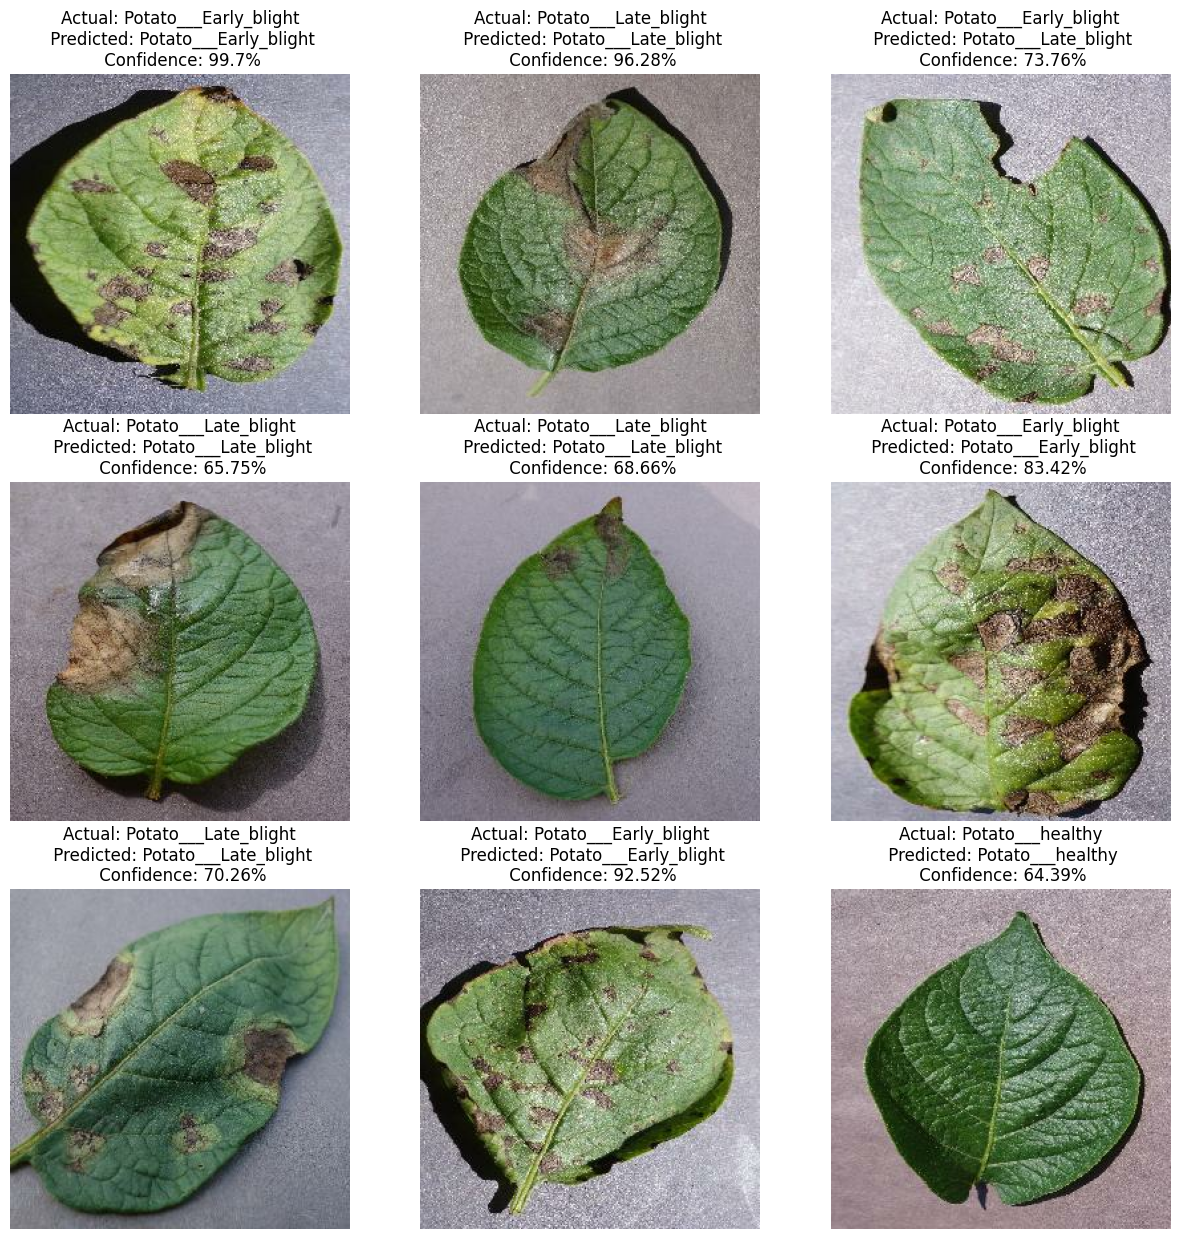

In [ ]:
plt.figure(figsize=(15, 15))  # Corrected the typo in 'plt.figure'

# Take the first batch from the test dataset
for images, labels in test_ds.take(1):
    # Iterate over the images in the batch
    for i in range(9):
        # Create subplots in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)  # Corrected the typo in 'plt.subplot'

        # Display the image
        plt.imshow(images[i].numpy().astype('uint8'))  # Corrected the typo in 'uint8'

        # Make predictions for the image using the predict function
        predicted_class, confidence = predict(model, images[i])  # Removed unnecessary 'numpy()'

        # Get the actual class label
        actual_class = class_names[labels[i]]

        # Set the title of the subplot with actual class, predicted class, and confidence
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")  # Corrected the newline character

        # Turn off axis
        plt.axis('off')

# Show the plot
plt.show()


In [ ]:
import os

# Define the directory path
directory_path = r"G:\potato project\training\saved_models"

# Check if the directory exists, if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Determine the next model version
model_versions = [int(i) for i in os.listdir(directory_path)] + [0]
model_version = max(model_versions) + 1

# Save the model to the appropriate directory
model.save(os.path.join(directory_path, str(model_version)))

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to preprocess the image
def preprocess_image(image_path):
    # Load the image from the given path
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    # Convert the image to an array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Expand dimensions to match the model input shape
    img_array = tf.expand_dims(img_array, 0)
    # Rescale pixel values
    img_array = img_array / 255.0
    return img_array

In [ ]:
# Function to make prediction
def predict_image(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    # Make prediction
    predictions = model.predict(img_array)
    # Get the predicted class label
    predicted_class = class_names[np.argmax(predictions)]
    # Get the confidence level of the prediction
    confidence = round(100 * np.max(predictions), 2)
    return predicted_class, confidence

# Function to display the image with prediction
def display_prediction(image_path):
    # Load and display the image
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Saving 0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG to 0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG
User uploaded file "0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG" with length 17908 bytes
1/1 [==============================] - 0s 107ms/step


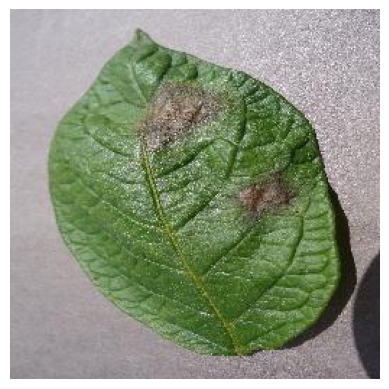

Predicted Class: Potato___Late_blight
Confidence: 53.09 %


In [ ]:
# List to store the paths of uploaded images
uploaded_image_paths = []

# Upload images from device
uploaded = files.upload()

# Iterate over uploaded files
for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=filename, length=len(uploaded[filename])))
    # Append the path of the uploaded image to the list
    uploaded_image_paths.append(filename)

# Iterate over uploaded image paths
for uploaded_image_path in uploaded_image_paths:
    # Make predictions using the preprocessed image and the trained model
    predicted_class, confidence = predict_image(model, uploaded_image_path)

    # Display the image with the predicted class label and confidence level
    display_prediction(uploaded_image_path)
    print("Predicted Class:", predicted_class)
    print("Confidence:", confidence, "%")

In [ ]:
import pickle

# Assuming 'model' is your trained TensorFlow model
with open('/content/drive/My Drive/potato project/training/model.pkl', 'wb') as f:
    pickle.dump(model, f)
